In [ ]:
# install Hangul font

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (5,022 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 124926 files and dire

In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.8 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
import seaborn as sns
import missingno as msno

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 현재 작업 디렉터리 출력
print(os.getcwd())

data_path = os.path.join(os.getcwd(), 'drive', 'MyDrive', 'Aimers_6th', 'Data')
print(data_path)

train = pd.read_csv(f'{data_path}/train.csv').drop(columns=['ID'])
test = pd.read_csv(f'{data_path}/test.csv').drop(columns=['ID'])

Mounted at /content/drive
/content
/content/drive/MyDrive/Aimers_6th/Data


In [ ]:
selected_cols = [
    '난자 출처',
    '정자 출처',
    '난자 기증자 나이',
    '정자 기증자 나이',
    '동결 배아 사용 여부',
    '신선 배아 사용 여부',
    '기증 배아 사용 여부',
    '대리모 여부',
    'PGD 시술 여부',
    'PGS 시술 여부',
    '난자 채취 경과일',
    '난자 해동 경과일',
    '난자 혼합 경과일',
    '배아 이식 경과일',
    '배아 해동 경과일']
target = '임신 성공 여부'

# 시술유형에 따라 세 그룹: ALL, IVF, DI
datasets = {
    'ALL': train,
    'IVF': train[train['시술 유형'] == 'IVF'],
    'DI': train[train['시술 유형'] == 'DI']
}

In [ ]:
# 성공/실패 카운트 및 비율을 포함하여 데이터프레임 변환
def get_success_distribution(df, col, target):
    summary = df.groupby(col)[target].agg(total='count', success_count='sum')
    summary['failure_count'] = summary['total'] - summary['success_count']
    summary['success_ratio'] = summary['success_count'] / summary['total']
    summary['failure_ratio'] = summary['failure_count'] / summary['total']

    # 합계 행 추가
    total_row = summary.sum(numeric_only=True)
    total_row.name = 'Total'
    total_row['success_ratio'] = total_row['success_count'] / total_row['total'] if total_row['total'] != 0 else 0
    total_row['failure_ratio'] = total_row['failure_count'] / total_row['total'] if total_row['total'] != 0 else 0

    summary = pd.concat([summary, total_row.to_frame().T])

    return summary

def count_ratio(df, col, target):
  summary_df =  df.groupby(col)[target].agg(total='count', success_count='sum')
  summary_df['failure_count'] = summary_df['total'] - summary_df['success_count']
  summary_df['success_ratio'] = summary_df['success_count'] / summary_df['total']
  summary_df['failure_ratio'] = summary_df['failure_count'] / summary_df['total']

  return summary_df

#count_ratio(datasets['ALL'], '시술 시기 코드', target)

def plot_success_failure_count(df, group, col, target, ax):
    summary_df = count_ratio(df[group], col, target)

    categories = summary_df.index
    success_counts = summary_df['success_count']
    failure_counts = summary_df['failure_count']
    total_counts = summary_df['total']
    success_ratios = summary_df['success_ratio']
    failure_ratios = summary_df['failure_ratio']

    ax1 = ax
    bar_width = 0.6

    p1 = ax1.bar(categories, success_counts, color='limegreen', label='성공 개수', width=bar_width)
    p2 = ax1.bar(categories, failure_counts, bottom=success_counts, color='royalblue', label='실패 개수', width=bar_width)

    ax1.set_title(f"<{group}> - \"{col}\" 항목 별 개수")
    ax1.set_ylim(0, max(total_counts) * 1.1)
    ax1.set_xticks(range(len(categories)))
    ax1.set_xticklabels(categories, rotation=45, ha='right')

    for i, total in enumerate(total_counts):
        ax1.text(i, total * 1.01, str(total), ha='center', fontsize=13)

    ax1.legend()

def plot_success_failure_ratio(df, group, col, target, ax):
    summary_df = count_ratio(df[group], col, target)

    categories = summary_df.index
    success_counts = summary_df['success_count']
    failure_counts = summary_df['failure_count']
    total_counts = summary_df['total']
    success_ratios = summary_df['success_ratio']
    failure_ratios = summary_df['failure_ratio']

    ax2 = ax
    ax2.barh(categories, success_ratios, color='limegreen', label='성공 비율')
    ax2.barh(categories, failure_ratios, left=success_ratios, color='royalblue', label='실패 비율')

    ax2.set_title(f"<{group}> - \"{col}\" 성공/실패 비율")
    ax2.set_xlabel("비율")
    ax2.set_yticks(categories)

    for i, (success_ratio, failure_ratio) in enumerate(zip(success_ratios, failure_ratios)):
        ax2.text(success_ratio / 2, i, f"{success_ratio * 100:.1f}%", ha='center', color='white', fontsize=13)
        ax2.text(success_ratio + failure_ratio / 2, i, f"{failure_ratio * 100:.1f}%", ha='center', color='white', fontsize=13)

    ax2.legend()

## 결측값 확인

시술 유형에 따라 그룹을 3개로 나누어 결측치를 살펴보았습니다.

- ALL : IVF 시술 + DI 시술
- IVF 시술
- DI 시술


In [ ]:
#각 그룹 별 결측치 확인
ALL_null = datasets['ALL'][selected_cols].isnull().sum()
IVF_null = datasets['IVF'][selected_cols].isnull().sum()
DI_null = datasets['DI'][selected_cols].isnull().sum()

Null = pd.concat([ALL_null, IVF_null, DI_null], axis=1)
Null.columns = ['ALL', 'IVF', 'DI']

display(Null)

,ALL,IVF,DI
난자 출처,0,0,0
정자 출처,0,0,0
난자 기증자 나이,0,0,0
정자 기증자 나이,0,0,0
동결 배아 사용 여부,6291,0,6291
신선 배아 사용 여부,6291,0,6291
기증 배아 사용 여부,6291,0,6291
대리모 여부,6291,0,6291
PGD 시술 여부,254172,247881,6291
PGS 시술 여부,254422,248131,6291


맡은 부분에서 전반적으로 결측치가 다량 존재했습니다.
- DI의 경우, 대부분이 6291로 전수 결측치 (100%)
- IVF에서는 특히 **PGD 시술 여부**,  **PGS 시술 여부**,  **난자 해동 경과일**,  **배아 해동 경과일**이 특히 결측치의 수가 많음 (결측치 80% 이상)

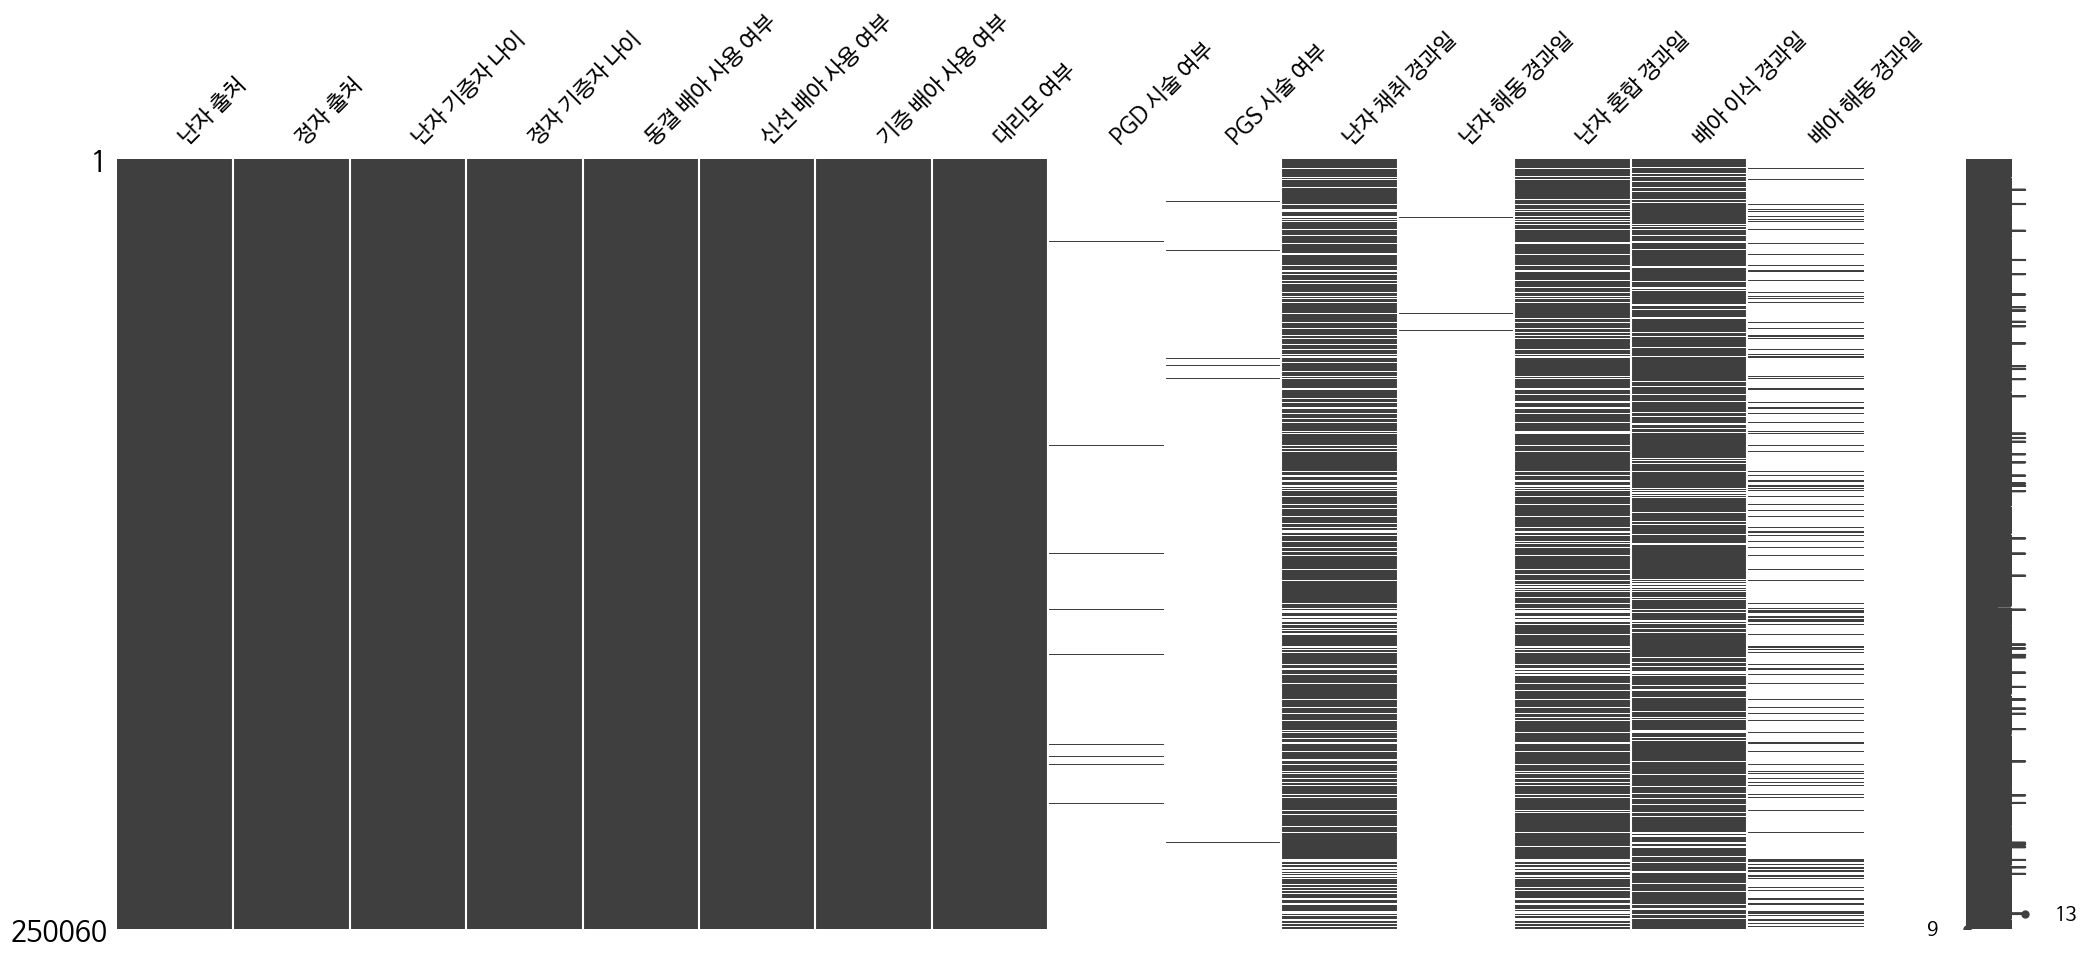

In [ ]:
msno.matrix(datasets['IVF'][selected_cols])
plt.show()

## 시술 유형 [DI]

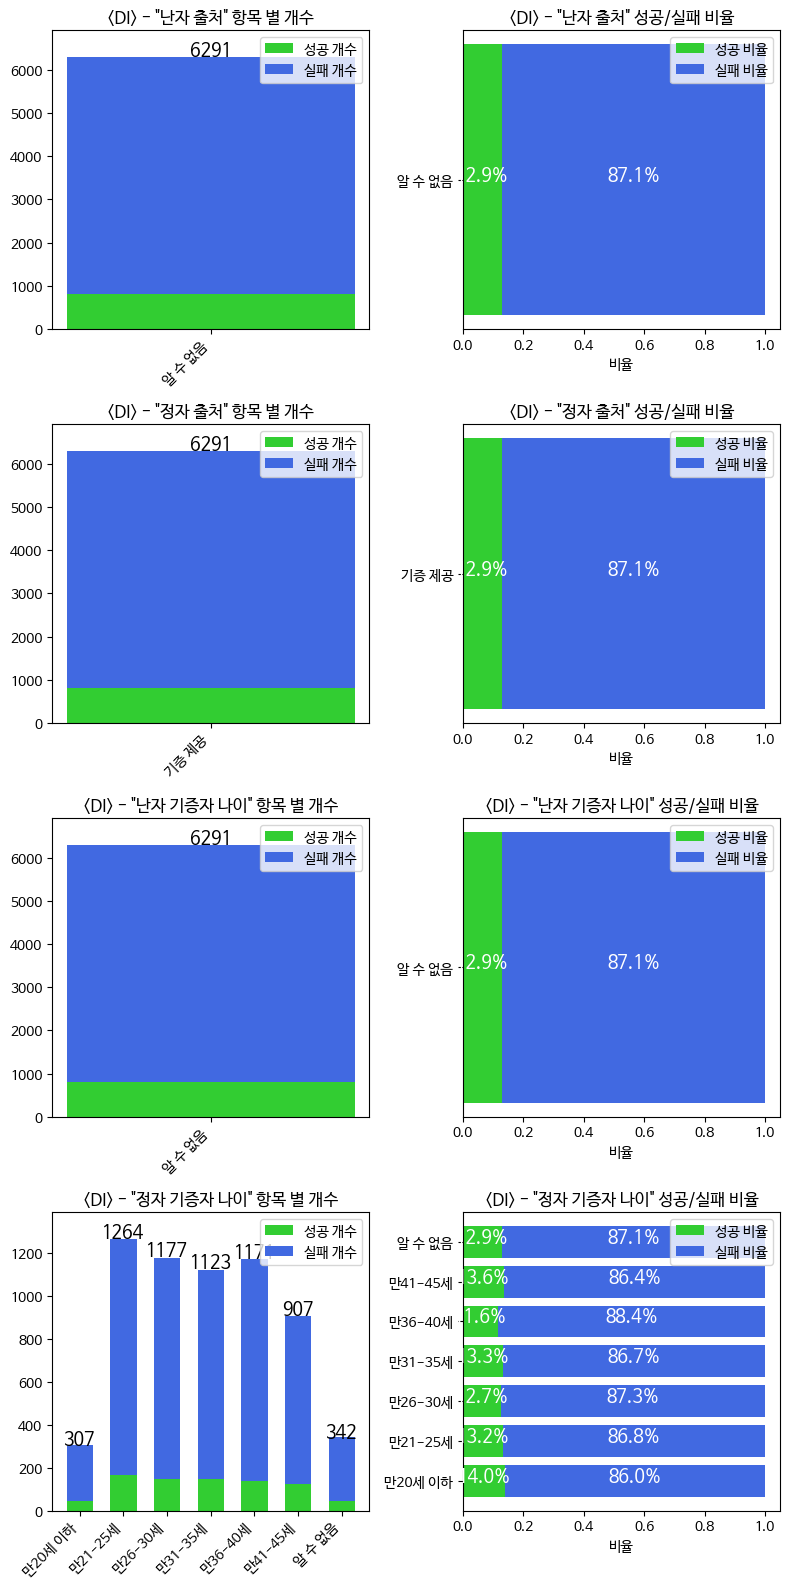

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(8, 16))
plot_success_failure_count(datasets, 'DI', '난자 출처', target, axes[0,0])
plot_success_failure_ratio(datasets, 'DI', '난자 출처', target, axes[0,1])
plot_success_failure_count(datasets, 'DI', '정자 출처', target, axes[1,0])
plot_success_failure_ratio(datasets, 'DI', '정자 출처', target, axes[1,1])
plot_success_failure_count(datasets, 'DI', '난자 기증자 나이', target, axes[2,0])
plot_success_failure_ratio(datasets, 'DI', '난자 기증자 나이', target, axes[2,1])
plot_success_failure_count(datasets, 'DI', '정자 기증자 나이', target, axes[3,0])
plot_success_failure_ratio(datasets, 'DI', '정자 기증자 나이', target, axes[3,1])
plt.tight_layout()
plt.show()

시술 유형 DI에 대해서 결측값 없는 컬럼 4개 확인 / 53번,54번,55번 컬럼은 DI 시술의 특성 상 동일한 값만 존재


53. 난자 출처 - 알 수 없음 (DI는 난자를 채취하지 않음)
54. 정자 출처 - 기증 제공 (DI - Donor Insemination / 기증 정자 인공 수정)
55. 난자 기증자 나이 - 알 수 없음 (DI는 난자를 기증 받지 않음)


---


<난자 출처와 난자 기증자 나이가 전부 알 수 없음>
- IVF의 경우에도 알 수 없음 존재함.
- DI 시술 유형에서는 알 수 없음을 시술 특성에 의한 결측치로 간주할 수도 있을 것 같습니다.


<정자 출처가 전부 기증 제공>
- 전부 기증 제공이므로 DI 시술 유형의 성공 여부 예측에 유의미한 영향을 주지 않을 것으로 보입니다.


---



>53~67 컬럼 중에서 56번 정자 기증자 나이만이 DI 시술 유형에서 사용 가능한 변수임을 확인하였습니다.

## 시술 유형 [IVF]

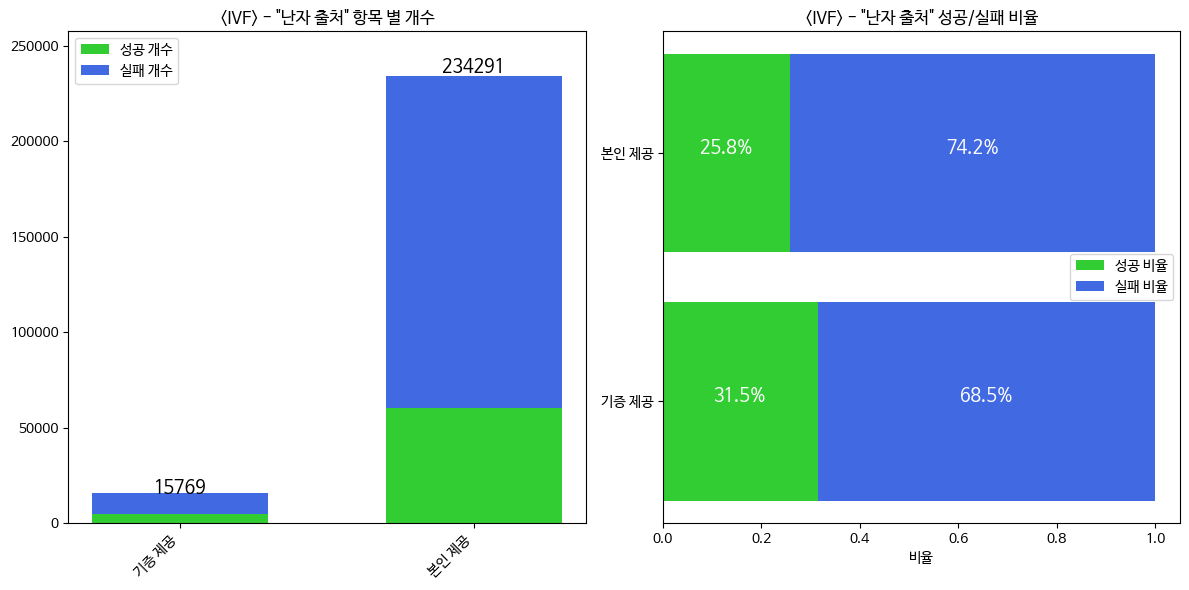

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12, 6))
plot_success_failure_count(datasets, 'IVF', '난자 출처', target, axes[0])
plot_success_failure_ratio(datasets, 'IVF', '난자 출처', target, axes[1])
plt.tight_layout()
plt.show()

53. 난자 출처
- 대부분 본인 제공
- 하지만 기증 제공에서 성공 비율이 더 높은 편

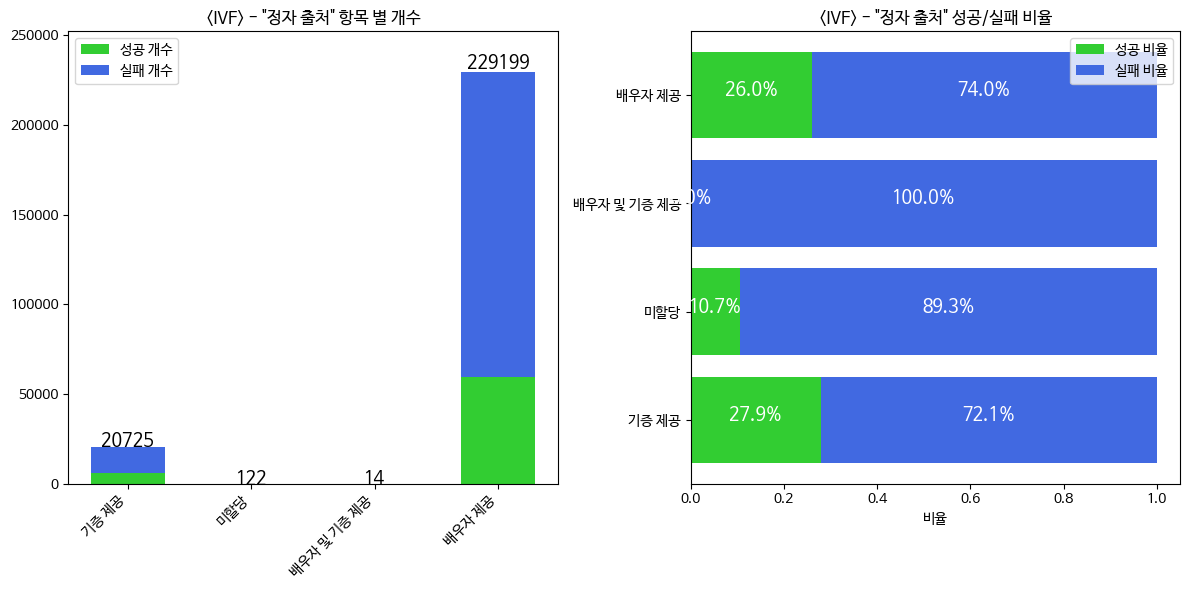

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12, 6))
plot_success_failure_count(datasets, 'IVF', '정자 출처', target, axes[0])
plot_success_failure_ratio(datasets, 'IVF', '정자 출처', target, axes[1])
plt.tight_layout()
plt.show()

54. 정자 출처
- 배우자 제공이 거의 대부분을 차지하며 그 다음이 기증 제공
- 미할당 , 배우자 및 기증 제공은 매우 희소

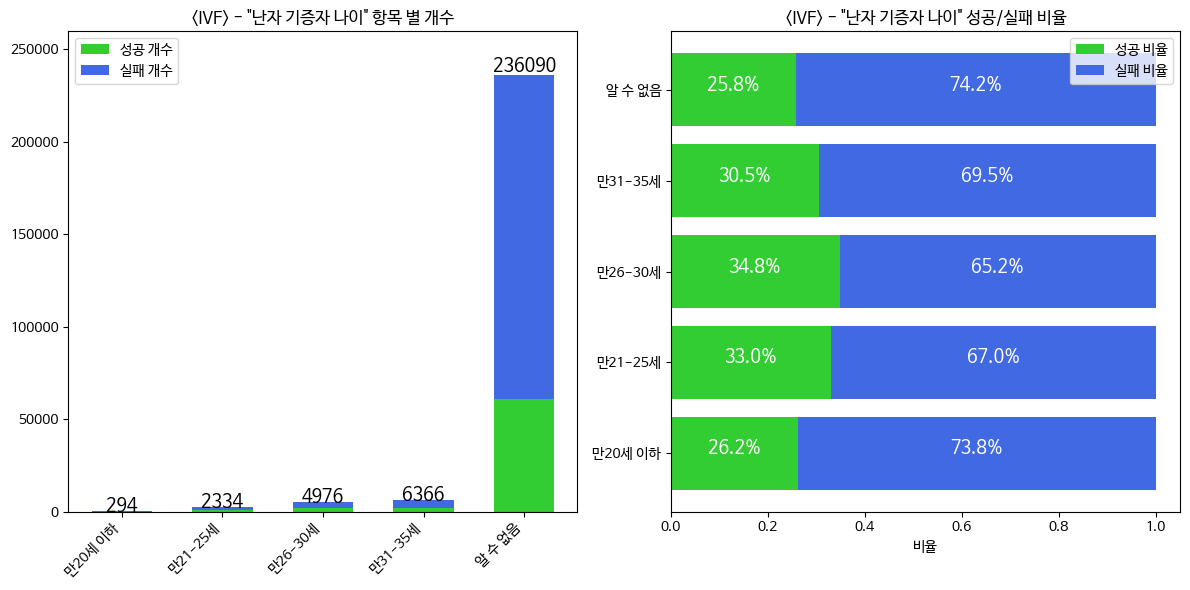

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12, 6))
plot_success_failure_count(datasets, 'IVF', '난자 기증자 나이', target, axes[0])
plot_success_failure_ratio(datasets, 'IVF', '난자 기증자 나이', target, axes[1])
plt.tight_layout()
plt.show()

55. 난자 기증자 나이
- 대부분이 알 수 없음으로 나타났습니다.
- 난자 출처가 본인 제공인 경우, 난자 기증자 나이가 전부 알 수 없음임을 확인했습니다.

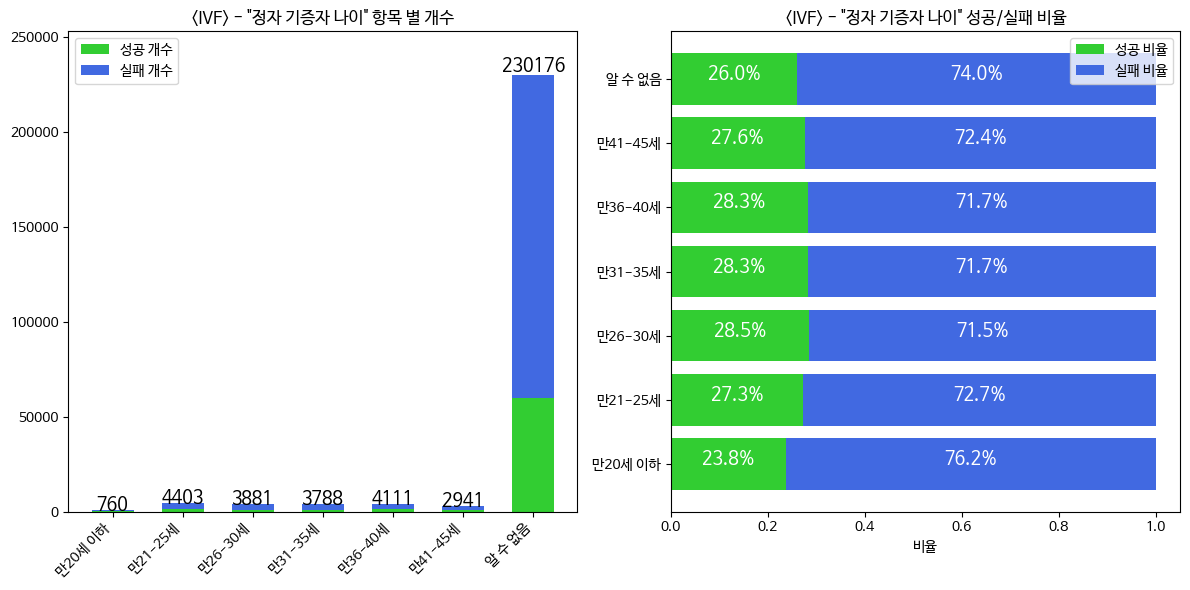

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12, 6))
plot_success_failure_count(datasets, 'IVF', '정자 기증자 나이', target, axes[0])
plot_success_failure_ratio(datasets, 'IVF', '정자 기증자 나이', target, axes[1])
plt.tight_layout()
plt.show()

56. 정자 기증자 나이
- 대부분이 알 수 없음
- 성공 비율 또한 두드러지는 차이는 없으나 만 20세 이하에서 가장 낮은 성공률을 보인다는 점이 눈에 띔 (데이터 수가 적어 왜곡 가능성)

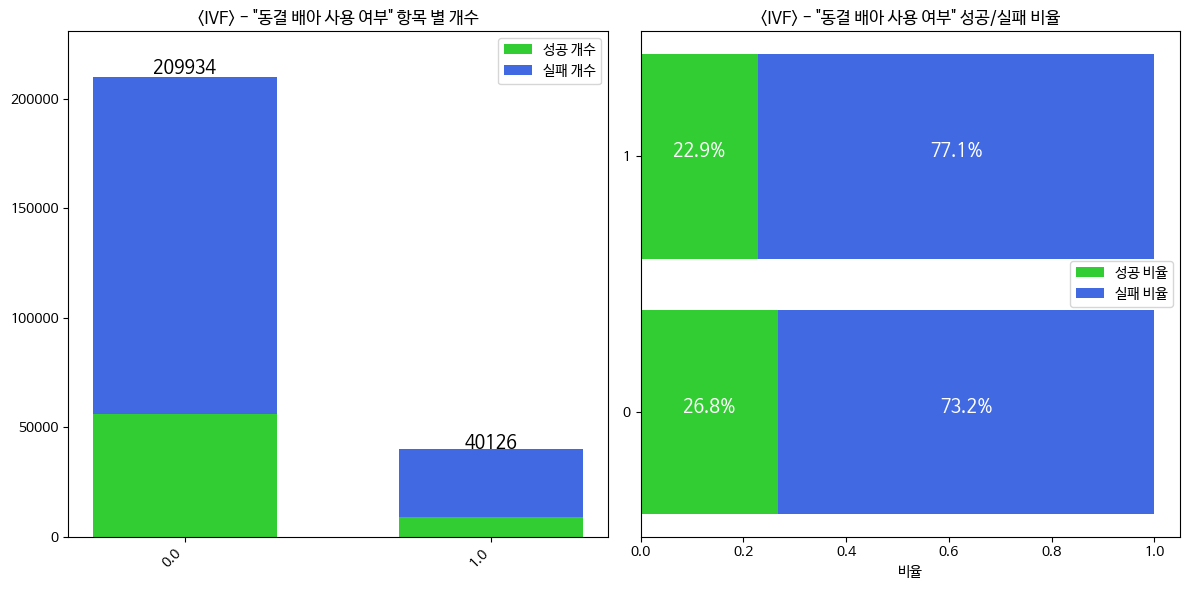

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12, 6))
plot_success_failure_count(datasets, 'IVF', '동결 배아 사용 여부', target, axes[0])
plot_success_failure_ratio(datasets, 'IVF', '동결 배아 사용 여부', target, axes[1])
plt.tight_layout()
plt.show()

57. 동결 배아 사용 여부
- 대부분 0 (동결 배아 사용 잘 사용 X)
- 동결 배아 사용 시, 성공 비율이 약간 더 낮은 편

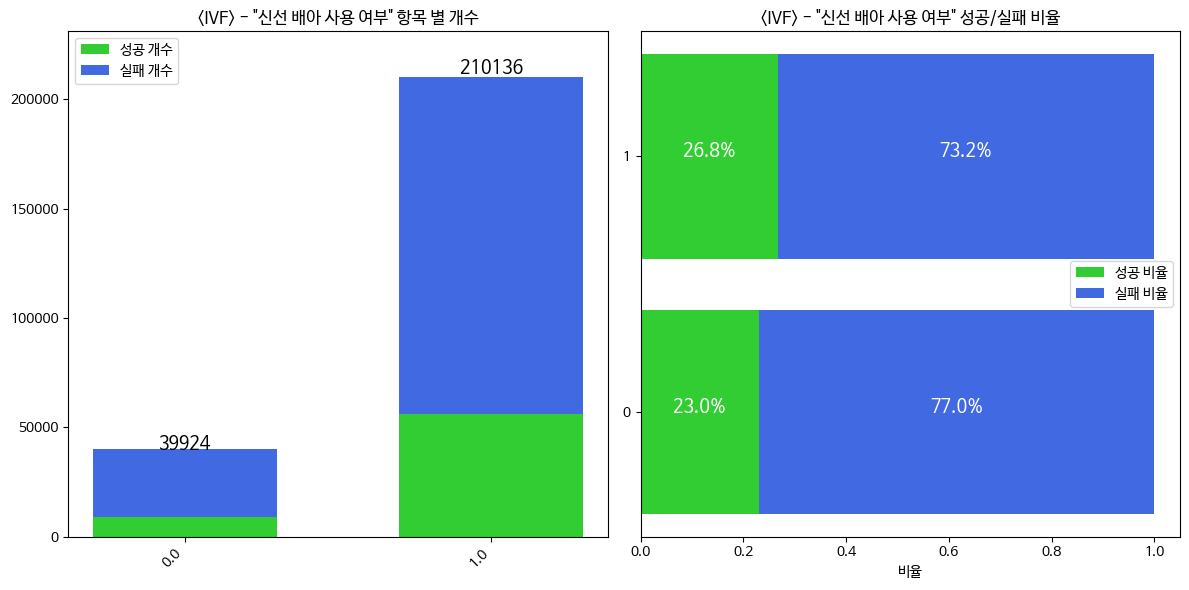

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12, 6))
plot_success_failure_count(datasets, 'IVF', '신선 배아 사용 여부', target, axes[0])
plot_success_failure_ratio(datasets, 'IVF', '신선 배아 사용 여부', target, axes[1])
plt.tight_layout()
plt.show()

58. 신선 배아 사용 여부
- 대부분 1 (신선 배아 사용이 더 많음)
- 신선 배아 사용 시, 성공 비율이 약간 더 높은 편

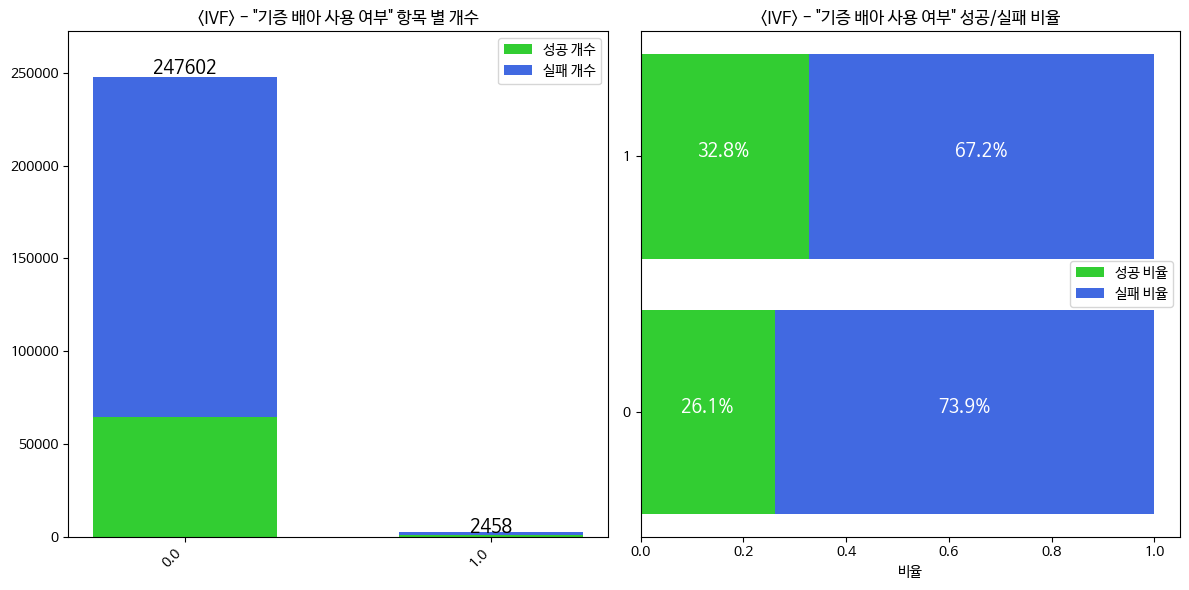

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12, 6))
plot_success_failure_count(datasets, 'IVF', '기증 배아 사용 여부', target, axes[0])
plot_success_failure_ratio(datasets, 'IVF', '기증 배아 사용 여부', target, axes[1])
plt.tight_layout()
plt.show()

59. 기증 배아 사용 여부 : 99% 이상이 0으로 기증 받은 배아를 사용하는 경우는 극히 드뭄

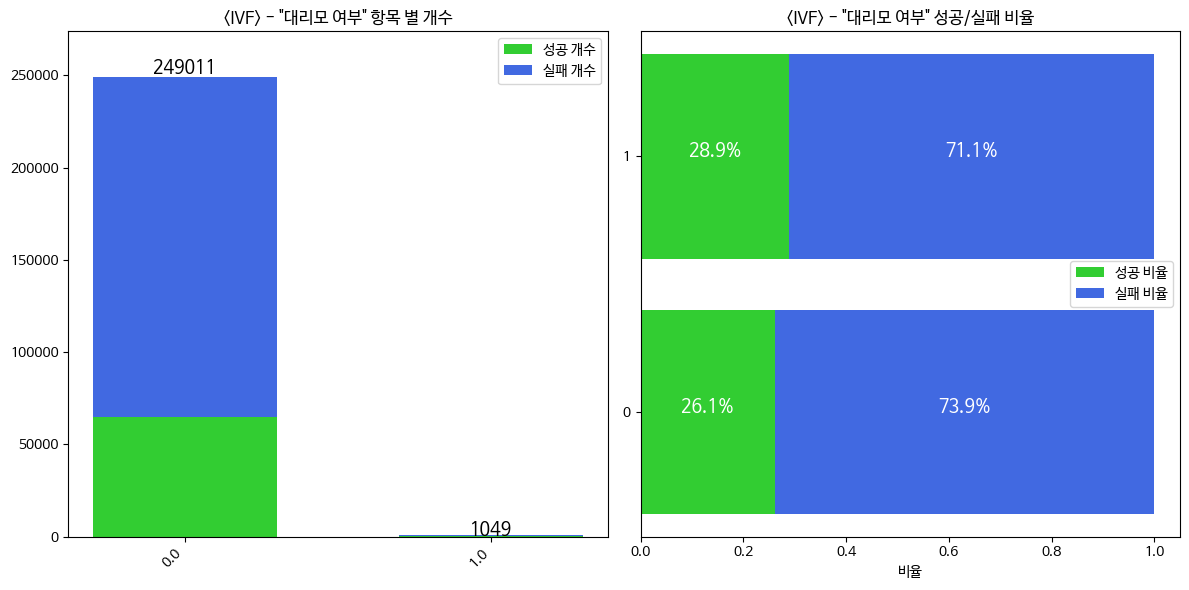

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12, 6))
plot_success_failure_count(datasets, 'IVF', '대리모 여부', target, axes[0])
plot_success_failure_ratio(datasets, 'IVF', '대리모 여부', target, axes[1])
plt.tight_layout()
plt.show()

60. 대리모 여부
- 이 주기에서 환자(실제 IVF 시술을 받는 사람)가 대리모의 역할을 하는 지 여부를 의미합니다.

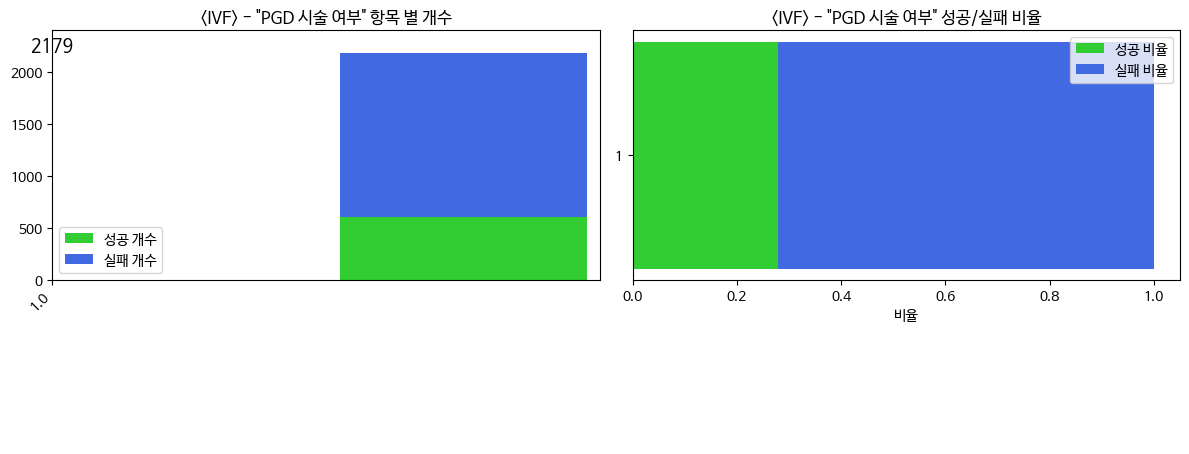

결측값 개수 : 247881, 결측 비율 : 96.70%


In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12, 6))
plot_success_failure_count(datasets, 'IVF', 'PGD 시술 여부', target, axes[0])
plot_success_failure_ratio(datasets, 'IVF', 'PGD 시술 여부', target, axes[1])
plt.tight_layout()
plt.show()
print(f"결측값 개수 : {Null.loc['PGD 시술 여부']['IVF']}, 결측 비율 : {Null.loc['PGD 시술 여부']['IVF'] / train.shape[0] * 100:.2f}%")

61. PGD 시술 여부
- 1 또는 결측값만 존재
- 9번 컬럼(착상 전 유전 검사 사용 여부)와 그나마 연관
- 결측 비율이 96%로 매우 높다. 성공 비율도 크게 두드러진 특징 X

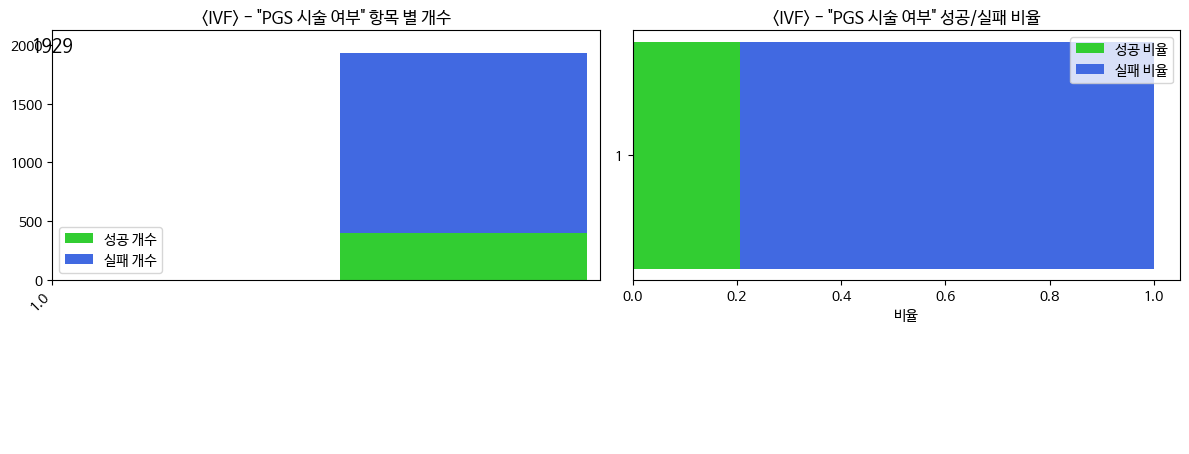

결측값 개수 : 248131, 결측 비율 : 96.79%


In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12, 6))
plot_success_failure_count(datasets, 'IVF', 'PGS 시술 여부', target, axes[0])
plot_success_failure_ratio(datasets, 'IVF', 'PGS 시술 여부', target, axes[1])
plt.tight_layout()
plt.show()
print(f"결측값 개수 : {Null.loc['PGS 시술 여부']['IVF']}, 결측 비율 : {Null.loc['PGS 시술 여부']['IVF'] / train.shape[0] * 100:.2f}%")

62. PGS 시술 여부
- 1 또는 결측값만 존재
- 10번 컬럼(착상 전 유전 진단 사용 여부)와 그나마 연관
- 결측 비율이 96%로 매우 높다. 성공 비율도 크게 두드러진 특징 X

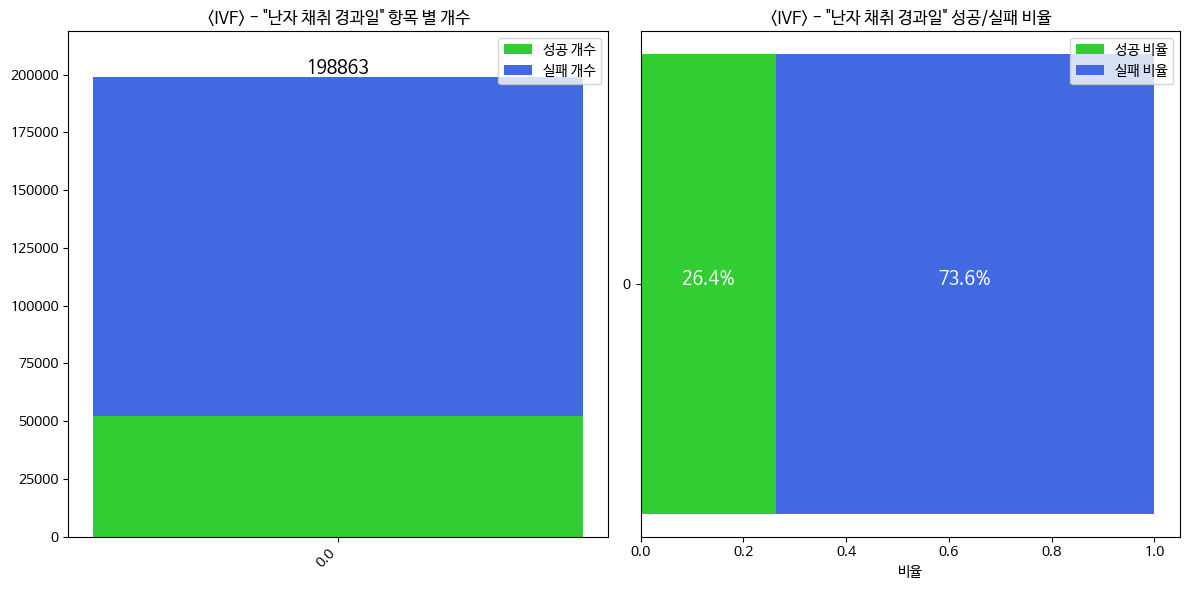

결측값 개수 : 51197, 결측 비율 : 19.97%


In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12, 6))
plot_success_failure_count(datasets, 'IVF', '난자 채취 경과일', target, axes[0])
plot_success_failure_ratio(datasets, 'IVF', '난자 채취 경과일', target, axes[1])
plt.tight_layout()
plt.show()
print(f"결측값 개수 : {Null.loc['난자 채취 경과일']['IVF']}, 결측 비율 : {Null.loc['난자 채취 경과일']['IVF'] / train.shape[0] * 100:.2f}%")

63. 난자 채취 경과일
- 결측값이 전체의 20%를 차지
- 결측값 외 나머지 모든 값이 0
- 결측값을 0으로 채워도 되는 지?

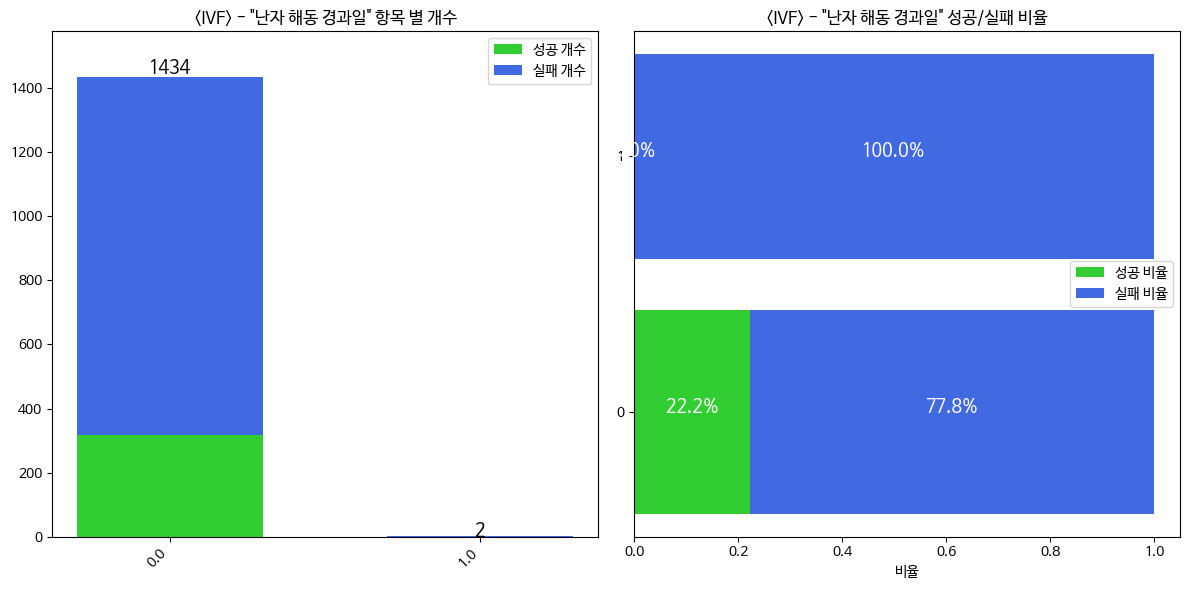

결측값 개수 : 248624, 결측 비율 : 96.99%


In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12, 6))
plot_success_failure_count(datasets, 'IVF', '난자 해동 경과일', target, axes[0])
plot_success_failure_ratio(datasets, 'IVF', '난자 해동 경과일', target, axes[1])
plt.tight_layout()
plt.show()
print(f"결측값 개수 : {Null.loc['난자 해동 경과일']['IVF']}, 결측 비율 : {Null.loc['난자 해동 경과일']['IVF'] / train.shape[0] * 100:.2f}%")

64. 난자 해동 경과일
- 전체에서 99%가 결측값
- 값이 있는 1436개의 데이터에서 단 2행만이 1(임신 성공)

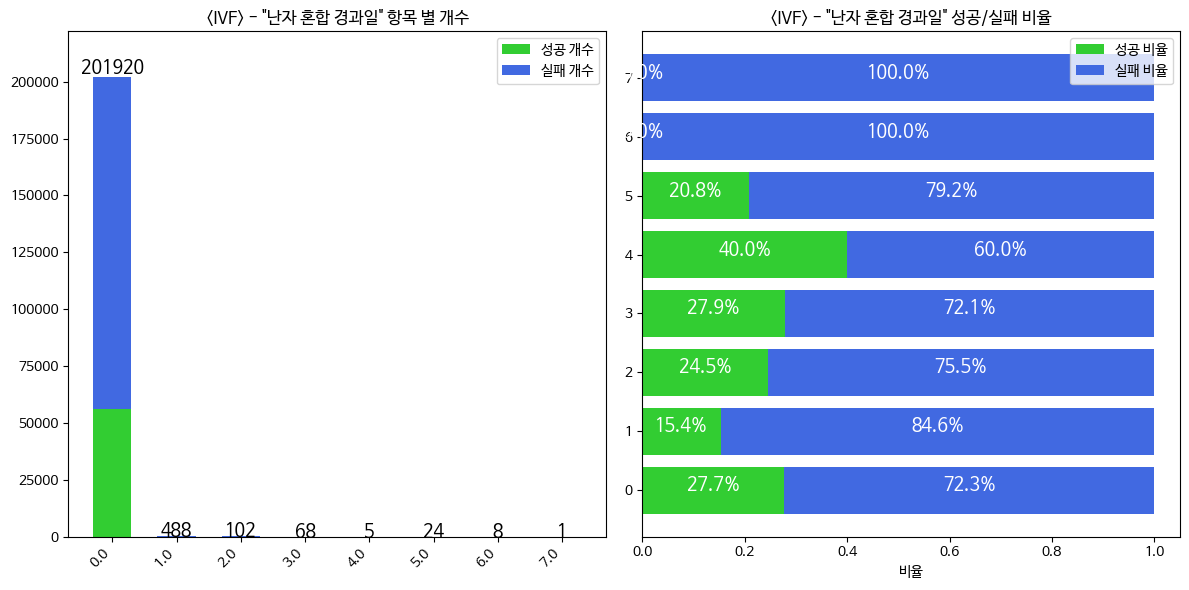

결측값 개수 : 47444, 결측 비율 : 18.51%


In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12, 6))
plot_success_failure_count(datasets, 'IVF', '난자 혼합 경과일', target, axes[0])
plot_success_failure_ratio(datasets, 'IVF', '난자 혼합 경과일', target, axes[1])
plt.tight_layout()
plt.show()
print(f"결측값 개수 : {Null.loc['난자 혼합 경과일']['IVF']}, 결측 비율 : {Null.loc['난자 혼합 경과일']['IVF'] / train.shape[0] * 100:.2f}%")

65. 난자 혼합 경과일
- 결측값이 전체의 19% 정도 차지. 거의 대부분이 0값, 1~7까지의 값이 아주 극소수 존재

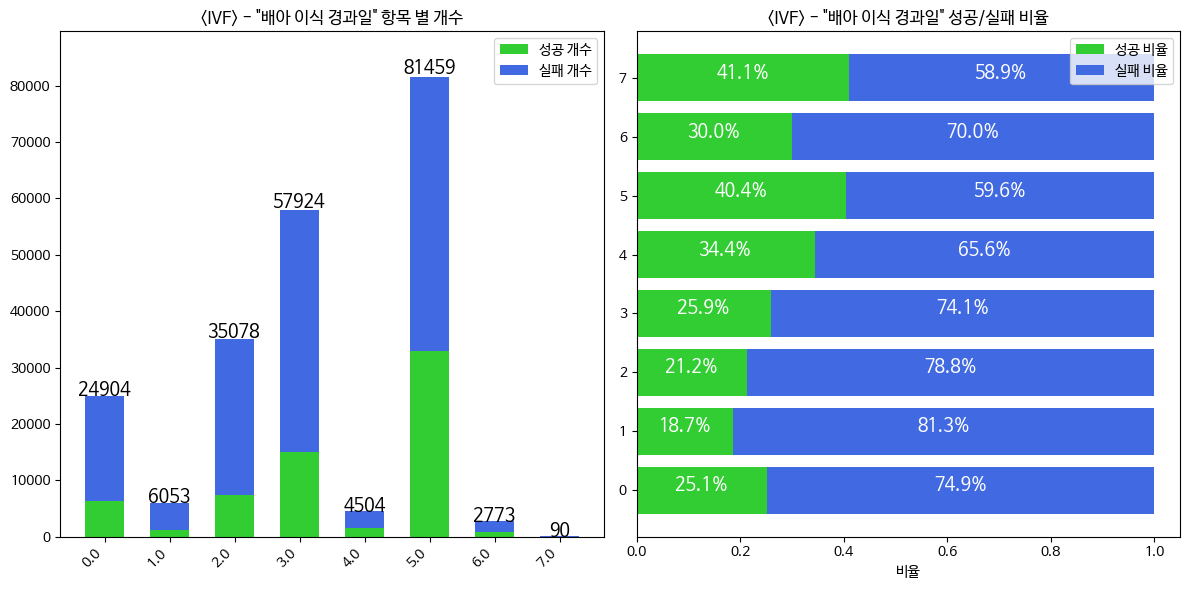

결측값 개수 : 37275, 결측 비율 : 14.54%


In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12, 6))
plot_success_failure_count(datasets, 'IVF', '배아 이식 경과일', target, axes[0])
plot_success_failure_ratio(datasets, 'IVF', '배아 이식 경과일', target, axes[1])
plt.tight_layout()
plt.show()
print(f"결측값 개수 : {Null.loc['배아 이식 경과일']['IVF']}, 결측 비율 : {Null.loc['배아 이식 경과일']['IVF'] / train.shape[0] * 100:.2f}%")

66. 배아 이식 경과일
- 0부터 7까지 다양한 값이 분포. 배란 경과일이 7일,5일인 경우에 성공율이 눈에 띄게 높은 편
- 아래에서 랜덤 포레스트로 돌렸을 때 모델 성능은 낮은 편이었지만 변수중요도가 다른 변수에 비해 앞도적으로 높음을 확인

> 모델 성능(AUC 0.6788), Feature  Importance (배아 이식 경과일 0.785958)

- 임신 성공 여부 예측 시, 중요한 특징이 되는 변수로 생각됩니다.

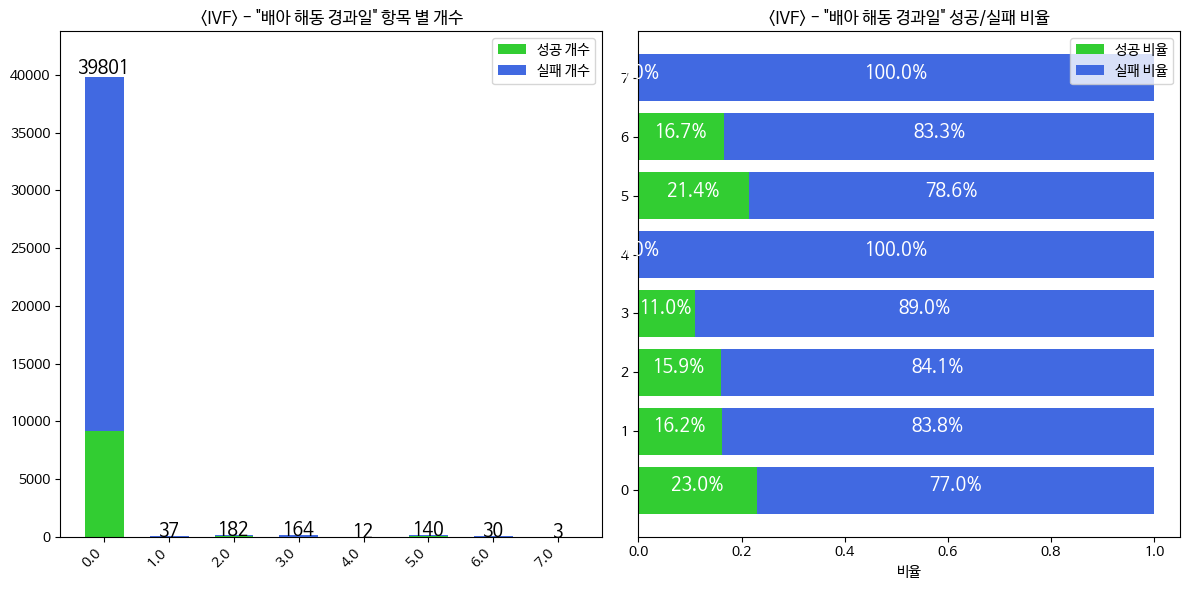

결측값 개수 : 209691, 결측 비율 : 81.80%


In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12, 6))
plot_success_failure_count(datasets, 'IVF', '배아 해동 경과일', target, axes[0])
plot_success_failure_ratio(datasets, 'IVF', '배아 해동 경과일', target, axes[1])
plt.tight_layout()
plt.show()
print(f"결측값 개수 : {Null.loc['배아 해동 경과일']['IVF']}, 결측 비율 : {Null.loc['배아 해동 경과일']['IVF'] / train.shape[0] * 100:.2f}%")

67. 배아 해동 경과일
- 결측값이 전체를 84% 차지. 거의 대부분이 0값, 1~7까지의 값이 아주 극소수 존재

### 상관 행렬(Correlation Matrix)

<ipython-input-26-4889a1031838>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_corr['PGD 시술 여부'].fillna(0, inplace=True)
<ipython-input-26-4889a1031838>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

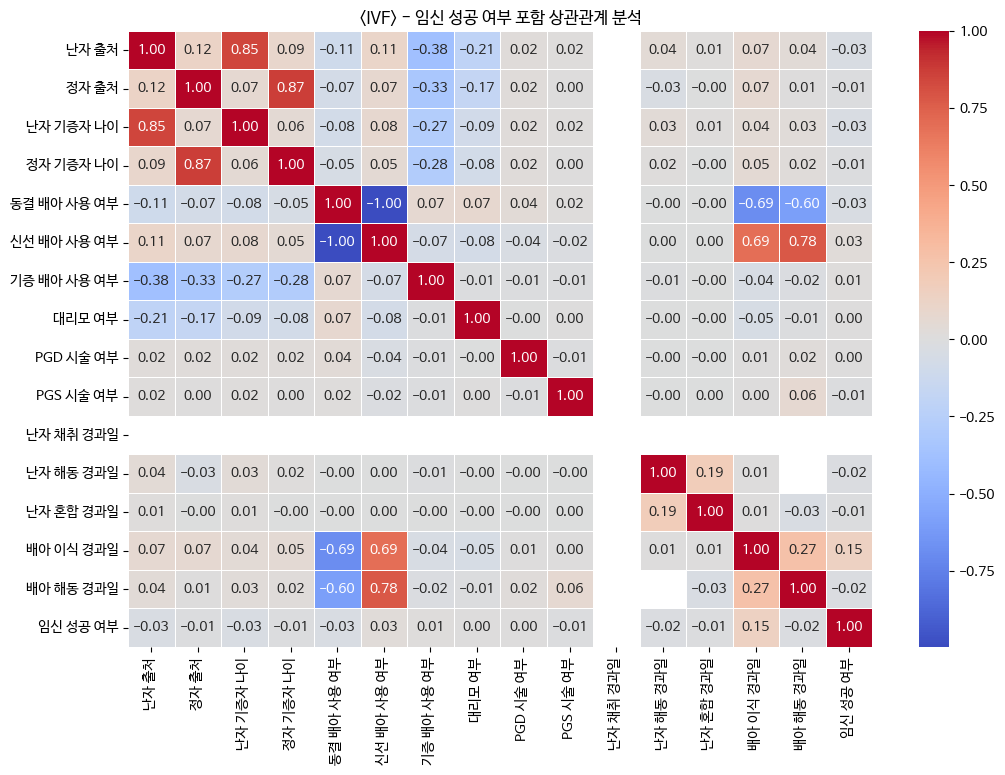

In [ ]:
df_corr = datasets['IVF'][selected_cols + [target]].copy()

df_corr['PGD 시술 여부'].fillna(0, inplace=True)
df_corr['PGS 시술 여부'].fillna(0, inplace=True)

# Label Encoding
for col in selected_cols:
    if df_corr[col].dtype == 'object' or df_corr[col].dtype.name == 'category':
        df_corr[col] = df_corr[col].astype('category').cat.codes  # 범주형 → 숫자 변환

corr_matrix = df_corr.corr()

# 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, cbar=True)
plt.title("<IVF> - 임신 성공 여부 포함 상관관계 분석")
plt.show()

[결측치 처리]
- PGD, PGS 시술 여부 : fillna(0)
- ~~경과일 : 결측값 처리 X


---


동결 배아 사용 여부와 신선 배아 사용 여부
 - 상관관계가 높은 음수값, 동결 배아와 신선 배아는 상호 보완적인 관계

난자 출처 & 난자 기증자 나이

정자 출처 & 정자 기증자 나이


신선 배아 사용 여부 & 배아 해동 경과일

신선 배아 사용 여부 & 배아 이식 경과일

동결 배아 사용 여부 & 배아 해동 경과일

동결 배아 사용 여부 & 배아 이식 경과일



### 랜덤포레스트 변수 중요도

Running: Label Encoding + Fill all with 0
Running: Label Encoding + 경과일: -1, Others: 0
Running: OneHot Encoding + Fill all with 0
Running: OneHot Encoding + 경과일: -1, Others: 0

 실험 결과:
          Encoding    Missing Handling  Average ROC AUC  Variance of ROC AUC
0   Label Encoding     Fill all with 0         0.679923             0.000003
1   Label Encoding  경과일: -1, Others: 0         0.681622             0.000004
2  OneHot Encoding     Fill all with 0         0.679658             0.000005
3  OneHot Encoding  경과일: -1, Others: 0         0.681274             0.000004

 Best Combination:
Encoding                   Label Encoding
Missing Handling       경과일: -1, Others: 0
Average ROC AUC                  0.681622
Variance of ROC AUC              0.000004
Name: 1, dtype: object


<ipython-input-27-66762f6101e3>:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=feature_importance, x='Importance', y='Feature', palette="viridis")


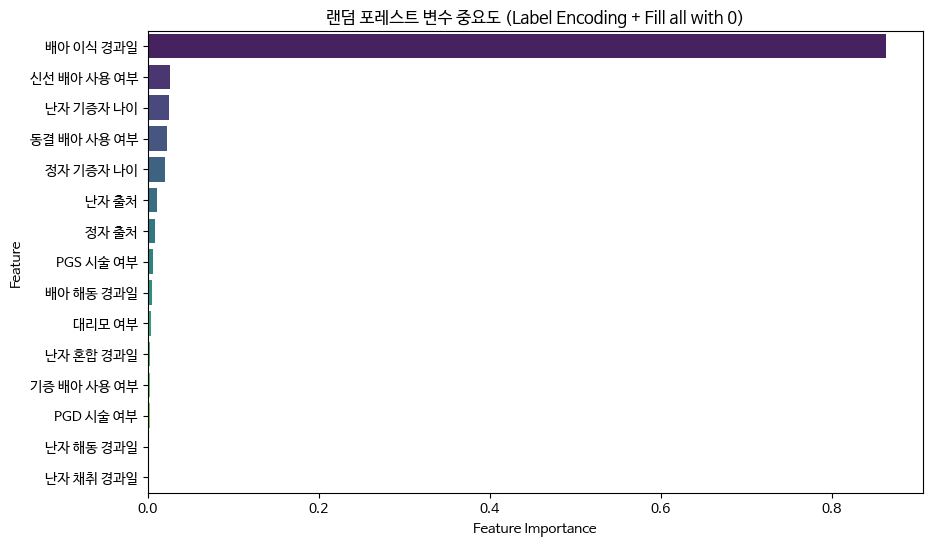

<ipython-input-27-66762f6101e3>:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=feature_importance, x='Importance', y='Feature', palette="viridis")


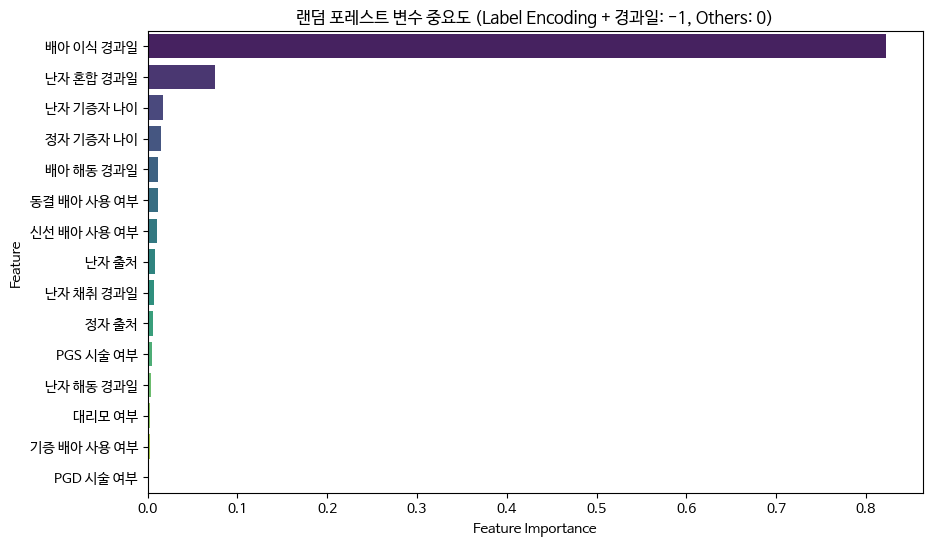

<ipython-input-27-66762f6101e3>:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=feature_importance, x='Importance', y='Feature', palette="viridis")


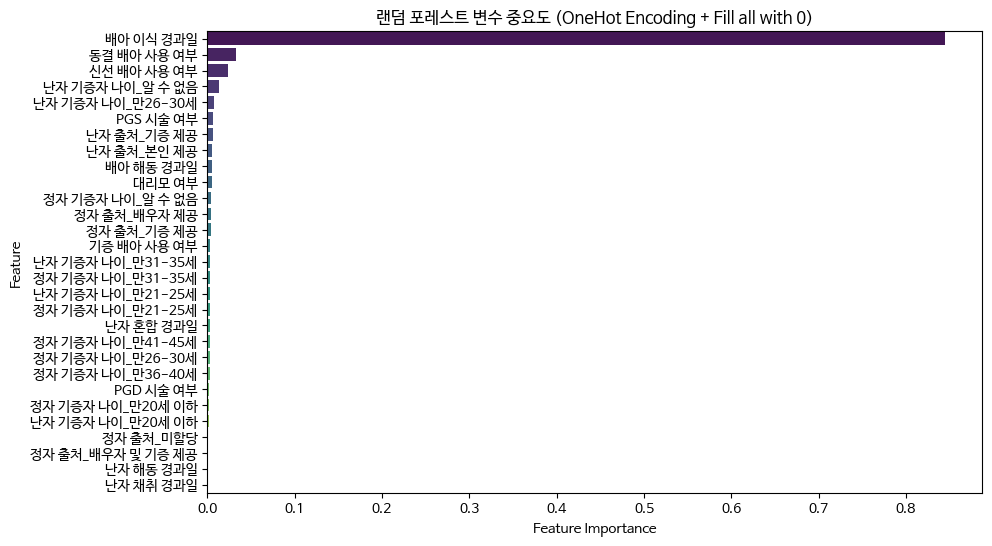

<ipython-input-27-66762f6101e3>:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=feature_importance, x='Importance', y='Feature', palette="viridis")


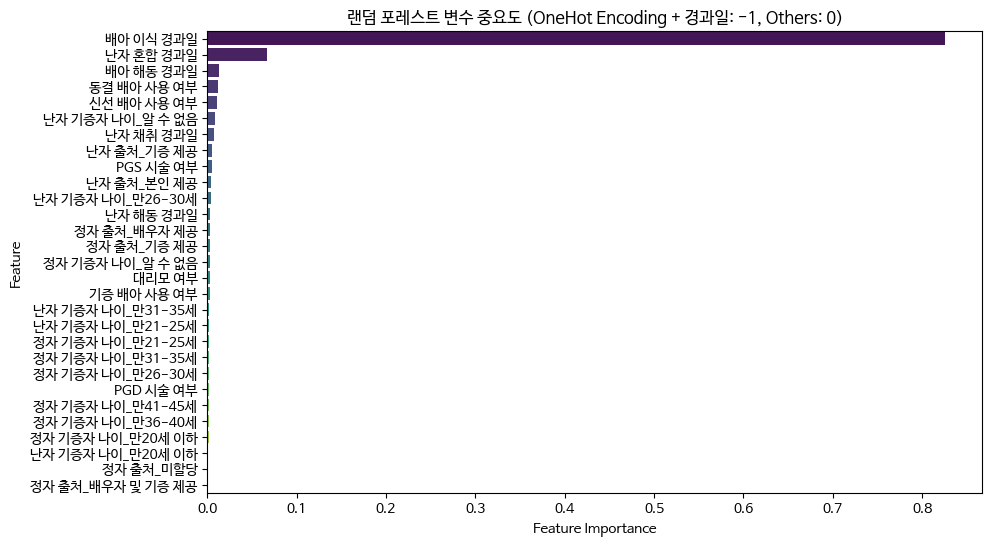


 Best Combination (Label Encoding + 경과일: -1, Others: 0) 변수 중요도


<ipython-input-27-66762f6101e3>:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=feature_importance_results[best_combination], x='Importance', y='Feature', palette="viridis")


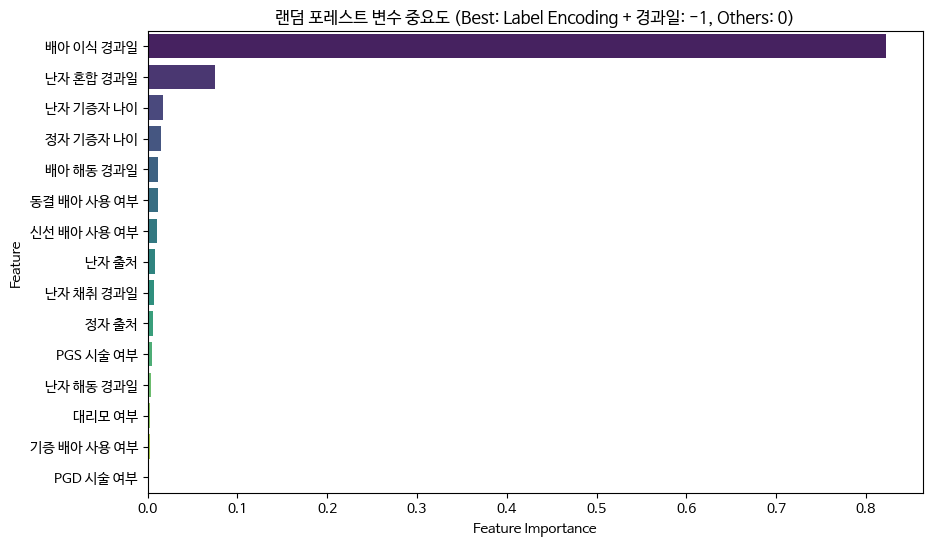

In [ ]:
# 1. 사용할 인코딩 방식 (라벨 인코딩 & 원핫 인코딩)
encoding_methods = {
    "Label Encoding": ce.OrdinalEncoder(cols=['난자 출처', '정자 출처', '난자 기증자 나이', '정자 기증자 나이']),
    "OneHot Encoding": ce.OneHotEncoder(cols=['난자 출처', '정자 출처', '난자 기증자 나이', '정자 기증자 나이'], use_cat_names=True)
}

# 2. 결측치 처리 방식
missing_value_methods = {
    "Fill all with 0": lambda df: df.fillna(0),  # 모든 결측값을 0으로 채우기
    "경과일: -1, Others: 0": lambda df: df.assign(
        **{col: df[col].fillna(-1) for col in [c for c in df.columns if c.endswith('경과일')]},
        **{col: df[col].fillna(0) for col in [c for c in df.columns if not c.endswith('경과일')]}
    )
}

# 3. 결과 저장용
results = []
feature_importance_results = {}

# 4. 각 인코딩 방식 & 결측치 처리 조합을 실행
for encoding_name, encoder in encoding_methods.items():
    for missing_method_name, missing_func in missing_value_methods.items():
        print(f"Running: {encoding_name} + {missing_method_name}")

        # 데이터 준비
        IVF_train_X = datasets['IVF'][selected_cols].copy()
        IVF_train_y = datasets['IVF'][target].copy()

        # 인코딩 적용
        IVF_train_X = encoder.fit_transform(IVF_train_X)

        # 결측치 처리
        IVF_train_X = missing_func(IVF_train_X)

        # K-Fold 설정
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        roc_auc_scores = []

        for train_index, test_index in kf.split(IVF_train_X, IVF_train_y):
            X_train, X_test = IVF_train_X.iloc[train_index], IVF_train_X.iloc[test_index]
            y_train, y_test = IVF_train_y.iloc[train_index], IVF_train_y.iloc[test_index]

            # RandomForest 모델 설정
            rf_model = RandomForestClassifier(
                n_jobs=1,
                random_state=42,
                n_estimators=200,
                max_depth=10,
                min_samples_leaf=1,
                max_samples=0.7
            )
            rf_model.fit(X_train, y_train)

            # ROC AUC 계산
            y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
            roc_auc = roc_auc_score(y_test, y_pred_prob)
            roc_auc_scores.append(roc_auc)

        # 평균 및 분산 계산
        avg_roc_auc = np.mean(roc_auc_scores)
        var_roc_auc = np.var(roc_auc_scores)

        # 결과 저장
        results.append({
            "Encoding": encoding_name,
            "Missing Handling": missing_method_name,
            "Average ROC AUC": avg_roc_auc,
            "Variance of ROC AUC": var_roc_auc
        })

        # 변수 중요도 저장
        feature_importance_results[f"{encoding_name} + {missing_method_name}"] = pd.DataFrame({
            'Feature': IVF_train_X.columns,
            'Importance': rf_model.feature_importances_
        }).sort_values(by='Importance', ascending=False)

# 5. 결과 출력 (표 형태)
results_df = pd.DataFrame(results)
print("\n 실험 결과:")
print(results_df)

# 6. 최적 조합 찾기
best_result = results_df.loc[results_df["Average ROC AUC"].idxmax()]
best_combination = f"{best_result['Encoding']} + {best_result['Missing Handling']}"
print("\n Best Combination:")
print(best_result)

# 7. 변수 중요도 시각화
for combination, feature_importance in feature_importance_results.items():
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=feature_importance, x='Importance', y='Feature', palette="viridis")
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title(f"랜덤 포레스트 변수 중요도 ({combination})")
    plt.show()

# 8. 최적 조합에 대한 변수 중요도 시각화
print(f"\n Best Combination ({best_combination}) 변수 중요도")
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=feature_importance_results[best_combination], x='Importance', y='Feature', palette="viridis")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title(f"랜덤 포레스트 변수 중요도 (Best: {best_combination})")
plt.show()


랜덤 포레스트 기반 변수 중요도 추출 (53번~67번 컬럼만 포함)

[결측치 처리]

1. 전부 0으로 채우기
2. PDG,PGS는 0으로 채우고 나머지 ~~경과일은 -1로 채우기

[인코딩 방식]

1. Ordinal Encoding
2. One-hot Encoding

> 모든 경우의 수를 돌려서 확인

결측치 처리 방식과 인코딩 방식이 달라지면 변수 중요도의 순위도 조금씩 바뀌나, 배아 이식 경과일 변수가 압도적으로 높음. 제일 중요한 변수.


